# EDA — Pitching-focused analysis

This notebook was auto-generated from `data/pa_decisions_2022_2023.parquet`. It focuses on pitching-related metrics requested: mean innings before pulled, number of pitches thrown, times through order, handedness percentages, pitch speeds, and pitch-type distributions. Visual assets have been saved to `data/viz/`.

## Detected relevant columns

### **Innings pitched (appearance-level)**
- **outs** → used to compute true innings pitched (`outs / 3`)
- **inning** → game inning (not used for IP calculation)

### **Pitcher identification & grouping**
- **pitcher_on_mound** → unique pitcher ID
- **game_pk** → unique game ID
- **appearance_id** (if present) → distinct pitcher appearance ID  
  *(If missing, appearances are grouped by pitcher + game)*

### **Pitch count & workload**
- **pitch_count** → cumulative pitch count for the appearance
- **pitcher_days_since_prev_game**

### **Times Through Order (TTO)**
- **tto**

### **Handedness**
- **p_throws** → L / R / S

### **Pitch velocity**
- **release_speed**

### **Pitch types**
- **type** → pitch classification
- **pitch_number** → pitch index within appearance

### **Pitcher metadata**
- **pitcher_is_left**
- **pitcher_is_right**

These columns are used to compute:
- True innings pitched before removal  
- Low-outing diagnostics (short IP, low pitch count, runs allowed)  
- Distribution plots for TTO, velocity, pitch types, and more.


## Data sample (first 5 rows)

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

pd.options.display.max_columns = 200
pd.set_option('display.max_rows', 200)

# Load data
df = pd.read_parquet('../data/processed/pa_decisions_2022_2023.parquet')

print(df.columns.tolist())
df.head()

['game_pk', 'game_date', 'game_year', 'pitch_number', 'at_bat_number', 'batter', 'pitcher_on_mound', 'home_team', 'away_team', 'stand', 'p_throws', 'inning', 'inning_topbot', 'outs', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b', 'bat_score', 'fld_score', 'bat_score_diff', 'home_score_diff', 'events', 'type', 'description', 'zone', 'bb_type', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'woba_value', 'estimated_woba_using_speedangle', 'launch_speed_angle', 'delta_run_exp', 'release_speed', 'release_spin_rate', 'pitcher_days_since_prev_game', 'n_priorpa_thisgame_player_at_bat_x', 'half', 'base_state', 'batting_team', 'fielding_team', 'score_diff', 'batter_is_left', 'batter_is_right', 'batter_is_switch', 'pitcher_is_left', 'pitcher_is_right', 'is_platoon_advantage', 'pitch_count', 'n_priorpa_thisgame_player_at_bat_y', 'tto', 'lineup_idx', 'next_hitters_ids', 'time_index_pa', 'delta_re_pa', 'half_inning_over', 'game_over', 'reward_folded', 'next_state_idx', 'action_idx', 'next_pitch

,game_pk,game_date,game_year,pitch_number,at_bat_number,batter,pitcher_on_mound,home_team,away_team,stand,p_throws,inning,inning_topbot,outs,balls,strikes,on_1b,on_2b,on_3b,bat_score,fld_score,bat_score_diff,home_score_diff,events,type,description,zone,bb_type,launch_speed,launch_angle,hit_distance_sc,woba_value,estimated_woba_using_speedangle,launch_speed_angle,delta_run_exp,release_speed,release_spin_rate,pitcher_days_since_prev_game,n_priorpa_thisgame_player_at_bat_x,half,base_state,batting_team,fielding_team,score_diff,batter_is_left,batter_is_right,batter_is_switch,pitcher_is_left,pitcher_is_right,is_platoon_advantage,pitch_count,n_priorpa_thisgame_player_at_bat_y,tto,lineup_idx,next_hitters_ids,time_index_pa,delta_re_pa,half_inning_over,game_over,reward_folded,next_state_idx,action_idx,next_pitcher_id
0,661032,2022-04-26,2022,1,1,664702,663776,LAA,CLE,R,L,1,Top,0,0,0,<NA>,<NA>,<NA>,0,0,0,0,strikeout,B,ball,14,None,<NA>,<NA>,<NA>,0.0,0.0,<NA>,0.037,94.7,2105,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,1,0,0,0,"[642708, 608070, 614177, 680911, 640458]",1650931200000000011,-0.247,False,False,0.740466,2,0,-1
1,661032,2022-04-26,2022,1,2,642708,663776,LAA,CLE,R,L,1,Top,1,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,S,called_strike,3,ground_ball,69.5,-30,3,0.0,0.062,2,-0.038,95.3,2207,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,5,0,0,1,"[608070, 614177, 680911, 640458, 676391]",1650931200000000015,-0.246,False,False,0.498450,2,0,-1
2,661032,2022-04-26,2022,1,3,608070,663776,LAA,CLE,R,L,1,Top,2,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,S,swinging_strike,8,fly_ball,73.5,46,213,0.0,0.011,3,-0.043,84.0,2264,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,7,0,0,2,"[614177, 680911, 640458, 676391, 595978]",1650931200000000017,-0.255,True,False,0.255000,2,0,-1
3,661032,2022-04-26,2022,1,7,614177,663776,LAA,CLE,R,L,2,Top,0,0,0,<NA>,<NA>,<NA>,0,0,0,0,strikeout,S,swinging_strike,13,None,<NA>,<NA>,<NA>,0.0,0.0,<NA>,-0.038,81.9,2820,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,10,0,0,3,"[680911, 640458, 676391, 595978, 665926]",1650931200000000029,-0.246,False,False,0.740446,5,0,-1
4,661032,2022-04-26,2022,1,8,680911,663776,LAA,CLE,R,L,2,Top,1,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,B,ball,11,fly_ball,86.3,43,289,0.0,0.014,3,0.036,81.7,2864,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,14,0,0,4,"[640458, 676391, 595978, 665926, 664702]",1650931200000000033,-0.246,False,False,0.499440,5,0,-1


## 1. Compute True Innings Pitched per Appearance

In [32]:
# Convert outs into innings pitched
df["outs_to_IP"] = df["outs"] / 3

# Choose keys based on dataset structure
if "appearance_id" in df.columns:
    group_keys = ["pitcher_on_mound", "game_pk", "appearance_id"]
else:
    group_keys = ["pitcher_on_mound", "game_pk"]

# Compute innings pitched per appearance
ip_per_app = (
    df.groupby(group_keys)["outs_to_IP"]
      .max()
      .reset_index(name="innings_pitched")
)

ip_per_app.head()

,pitcher_on_mound,game_pk,innings_pitched
0,405395,661984,0.666667
1,424144,662587,0.0
2,424144,662625,0.666667
3,424144,663341,0.666667
4,424144,663361,0.666667


## 2. Plot Innings Pitched Distribution

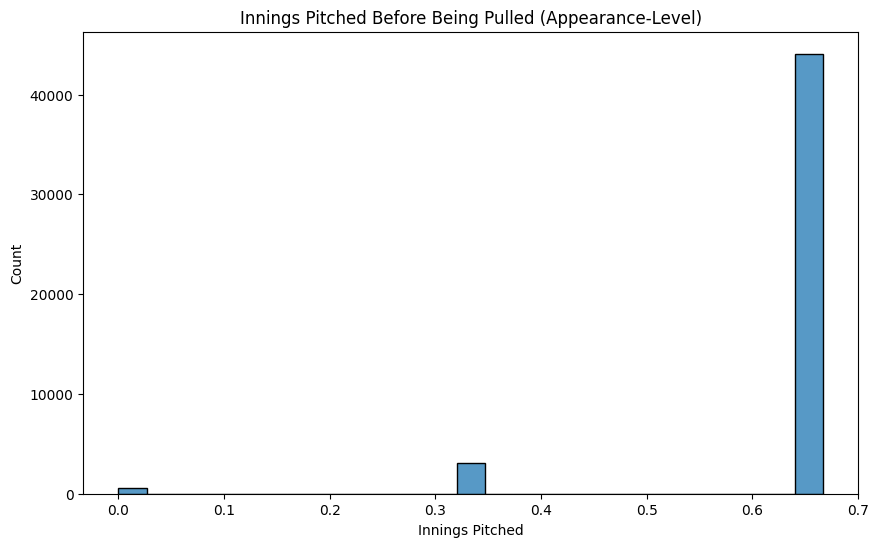

,pitcher_on_mound,game_pk,innings_pitched
count,47700.0,47700.0,47700.0
mean,620484.203522,692941.608595,0.637596
std,57232.714599,27379.28616,0.106894
min,405395.0,661032.0,0.0
25%,596001.0,662416.0,0.666667
50%,641585.0,707028.0,0.666667
75%,664199.0,717666.0,0.666667
max,806288.0,748585.0,0.666667


In [33]:
os.makedirs("viz", exist_ok=True)

plt.figure(figsize=(10,6))
sns.histplot(ip_per_app["innings_pitched"], bins=25)
plt.title("Innings Pitched Before Being Pulled (Appearance-Level)")
plt.xlabel("Innings Pitched")
plt.ylabel("Count")
plt.savefig("viz/innings_pitched_before_pull.png", dpi=300)
plt.show()

ip_per_app.describe()

## 3. Label Short Outings ( ≤ 3 IP ) and Plot Overlay

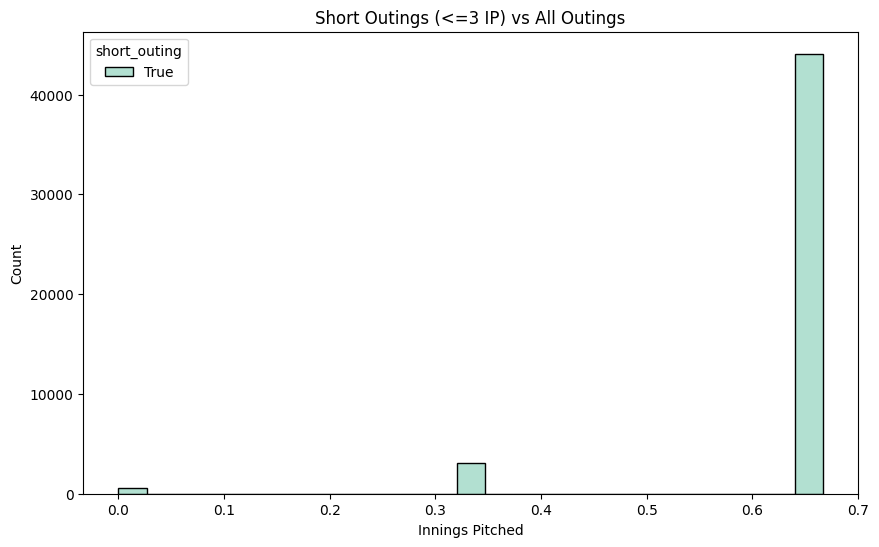

In [34]:
SHORT_IP_THRESHOLD = 3.0
ip_per_app["short_outing"] = ip_per_app["innings_pitched"] <= SHORT_IP_THRESHOLD

plt.figure(figsize=(10,6))
sns.histplot(
    data=ip_per_app, 
    x="innings_pitched", 
    hue="short_outing",
    bins=25,
    multiple="layer",
    palette="Set2"
)
plt.title("Short Outings (<=3 IP) vs All Outings")
plt.xlabel("Innings Pitched")
plt.ylabel("Count")
plt.savefig("viz/short_outings_overlay.png", dpi=300)
plt.show()

## Merge IP Back onto the Main DF

In [35]:
df2 = df.merge(ip_per_app, on=group_keys, how="left")
df2.head()

,game_pk,game_date,game_year,pitch_number,at_bat_number,batter,pitcher_on_mound,home_team,away_team,stand,p_throws,inning,inning_topbot,outs,balls,strikes,on_1b,on_2b,on_3b,bat_score,fld_score,bat_score_diff,home_score_diff,events,type,description,zone,bb_type,launch_speed,launch_angle,hit_distance_sc,woba_value,estimated_woba_using_speedangle,launch_speed_angle,delta_run_exp,release_speed,release_spin_rate,pitcher_days_since_prev_game,n_priorpa_thisgame_player_at_bat_x,half,base_state,batting_team,fielding_team,score_diff,batter_is_left,batter_is_right,batter_is_switch,pitcher_is_left,pitcher_is_right,is_platoon_advantage,pitch_count,n_priorpa_thisgame_player_at_bat_y,tto,lineup_idx,next_hitters_ids,time_index_pa,delta_re_pa,half_inning_over,game_over,reward_folded,next_state_idx,action_idx,next_pitcher_id,outs_to_IP,innings_pitched,short_outing
0,661032,2022-04-26,2022,1,1,664702,663776,LAA,CLE,R,L,1,Top,0,0,0,<NA>,<NA>,<NA>,0,0,0,0,strikeout,B,ball,14,None,<NA>,<NA>,<NA>,0.0,0.0,<NA>,0.037,94.7,2105,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,1,0,0,0,"[642708, 608070, 614177, 680911, 640458]",1650931200000000011,-0.247,False,False,0.740466,2,0,-1,0.0,0.666667,True
1,661032,2022-04-26,2022,1,2,642708,663776,LAA,CLE,R,L,1,Top,1,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,S,called_strike,3,ground_ball,69.5,-30,3,0.0,0.062,2,-0.038,95.3,2207,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,5,0,0,1,"[608070, 614177, 680911, 640458, 676391]",1650931200000000015,-0.246,False,False,0.498450,2,0,-1,0.333333,0.666667,True
2,661032,2022-04-26,2022,1,3,608070,663776,LAA,CLE,R,L,1,Top,2,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,S,swinging_strike,8,fly_ball,73.5,46,213,0.0,0.011,3,-0.043,84.0,2264,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,7,0,0,2,"[614177, 680911, 640458, 676391, 595978]",1650931200000000017,-0.255,True,False,0.255000,2,0,-1,0.666667,0.666667,True
3,661032,2022-04-26,2022,1,7,614177,663776,LAA,CLE,R,L,2,Top,0,0,0,<NA>,<NA>,<NA>,0,0,0,0,strikeout,S,swinging_strike,13,None,<NA>,<NA>,<NA>,0.0,0.0,<NA>,-0.038,81.9,2820,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,10,0,0,3,"[680911, 640458, 676391, 595978, 665926]",1650931200000000029,-0.246,False,False,0.740446,5,0,-1,0.0,0.666667,True
4,661032,2022-04-26,2022,1,8,680911,663776,LAA,CLE,R,L,2,Top,1,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,B,ball,11,fly_ball,86.3,43,289,0.0,0.014,3,0.036,81.7,2864,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,14,0,0,4,"[640458, 676391, 595978, 665926, 664702]",1650931200000000033,-0.246,False,False,0.499440,5,0,-1,0.333333,0.666667,True


## 4. Compute Total Pitches Thrown Per Appearance

In [36]:
pitch_count = (
    df.groupby(group_keys)["pitch_count"]
      .max()
      .reset_index(name="total_pitches")
)

df_ip_pitch = ip_per_app.merge(pitch_count, on=group_keys, how="left")

df_ip_pitch.head()

,pitcher_on_mound,game_pk,innings_pitched,short_outing,total_pitches
0,405395,661984,0.666667,True,25
1,424144,662587,0.0,True,10
2,424144,662625,0.666667,True,12
3,424144,663341,0.666667,True,1
4,424144,663361,0.666667,True,8


## 5. Pitch Count Histogram

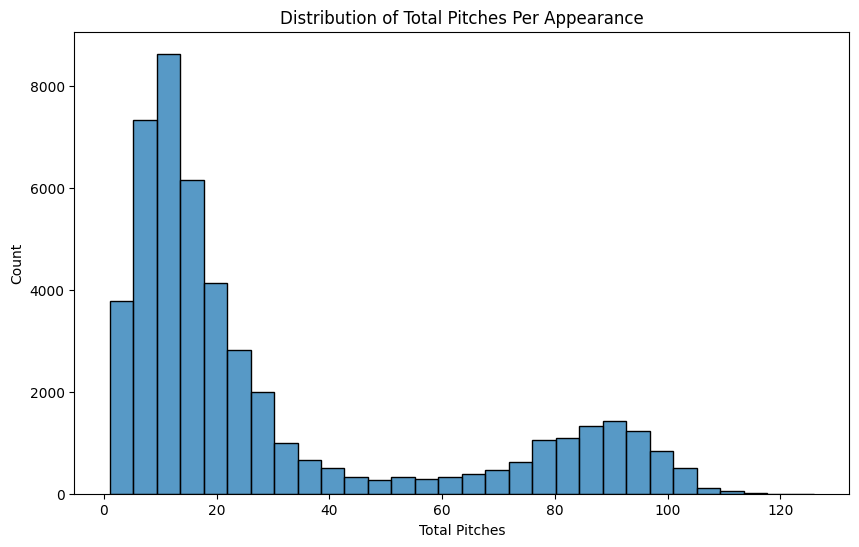

In [37]:
plt.figure(figsize=(10,6))
sns.histplot(df_ip_pitch["total_pitches"], bins=30)
plt.title("Distribution of Total Pitches Per Appearance")
plt.xlabel("Total Pitches")
plt.ylabel("Count")
plt.savefig("viz/pitch_count_distribution.png", dpi=300)
plt.show()

## Pitch Count: Short vs Normal Outings

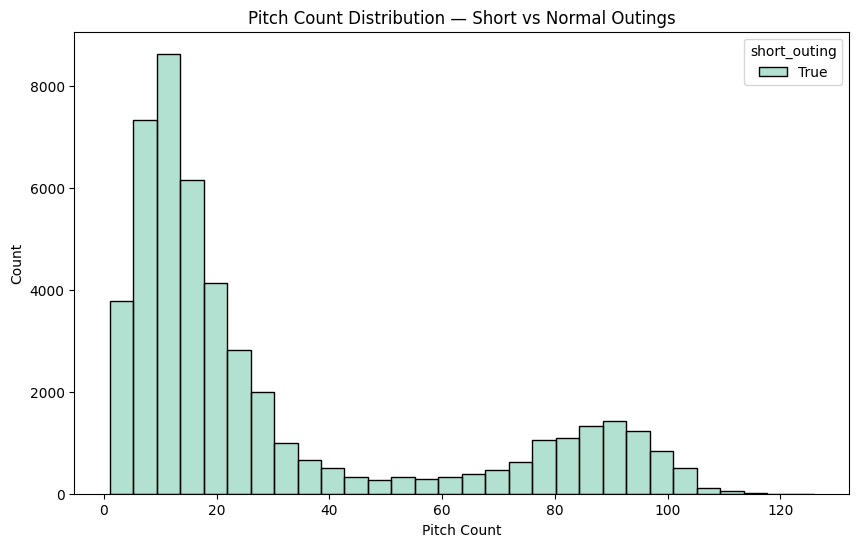

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_ip_pitch, 
    x="total_pitches", 
    hue="short_outing",
    bins=30,
    multiple="layer",
    palette="Set2"
)
plt.title("Pitch Count Distribution — Short vs Normal Outings")
plt.xlabel("Pitch Count")
plt.ylabel("Count")
plt.savefig("viz/pitchcount_short_overlay.png", dpi=300)
plt.show()

## 6. Runs Allowed if Present

In [39]:
if "events_run_scored" in df.columns:
    runs_allowed = (
        df.groupby(group_keys)["events_run_scored"]
          .sum()
          .reset_index(name="runs_allowed")
    )
    df_ip_pitch = df_ip_pitch.merge(runs_allowed, on=group_keys, how="left")

    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=df_ip_pitch, 
        y="runs_allowed", 
        x="short_outing"
    )
    plt.title("Runs Allowed — Short Outings vs Normal")
    plt.xlabel("Short Outing (<=3 IP)")
    plt.ylabel("Runs Allowed")
    plt.savefig("viz/runs_allowed_short_outings.png", dpi=300)
    plt.show()

## 7. IP vs Pitch Count Scatter Plot

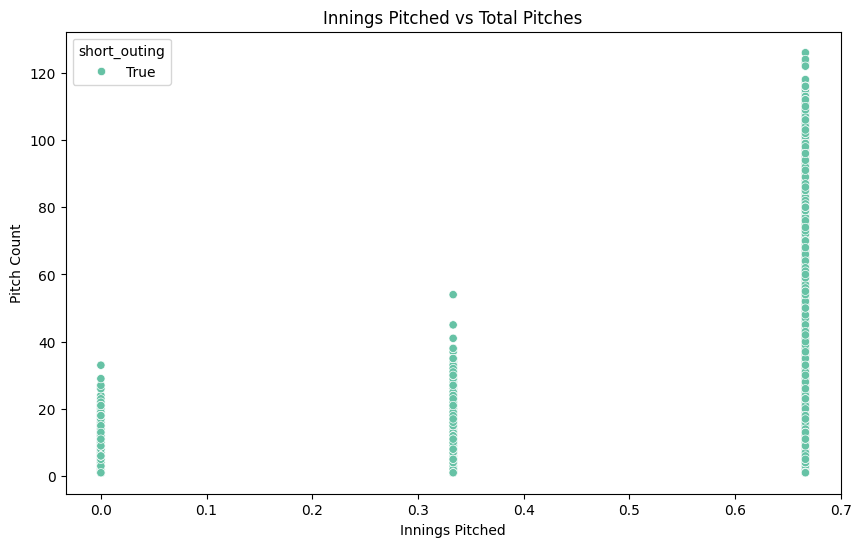

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_ip_pitch,
    x="innings_pitched",
    y="total_pitches",
    hue="short_outing",
    palette="Set2"
)
plt.title("Innings Pitched vs Total Pitches")
plt.xlabel("Innings Pitched")
plt.ylabel("Pitch Count")
plt.savefig("viz/ip_vs_pitchcount.png", dpi=300)
plt.show()

## 8. Times Through the Order (TTO) Distribution

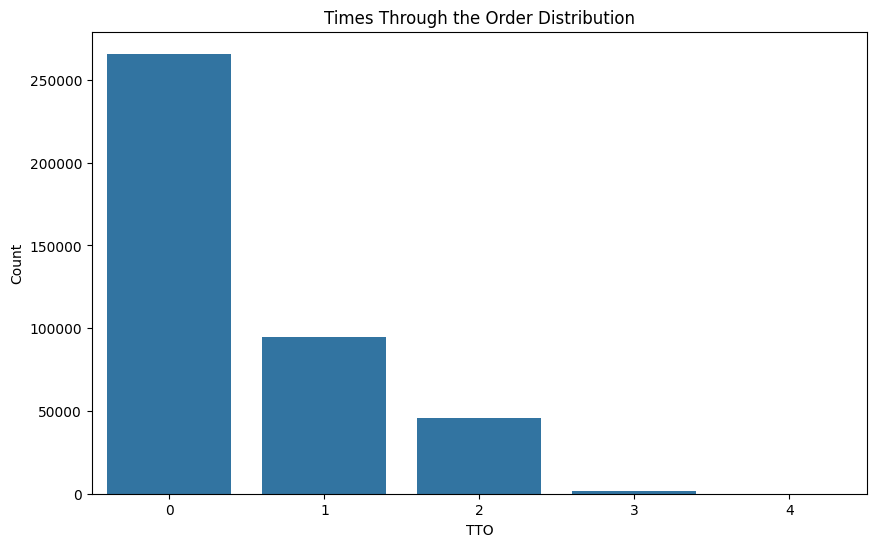

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(x=df["tto"])
plt.title("Times Through the Order Distribution")
plt.xlabel("TTO")
plt.ylabel("Count")
plt.savefig("viz/tto_distribution.png", dpi=300)
plt.show()

## 9. Handedness Distribution

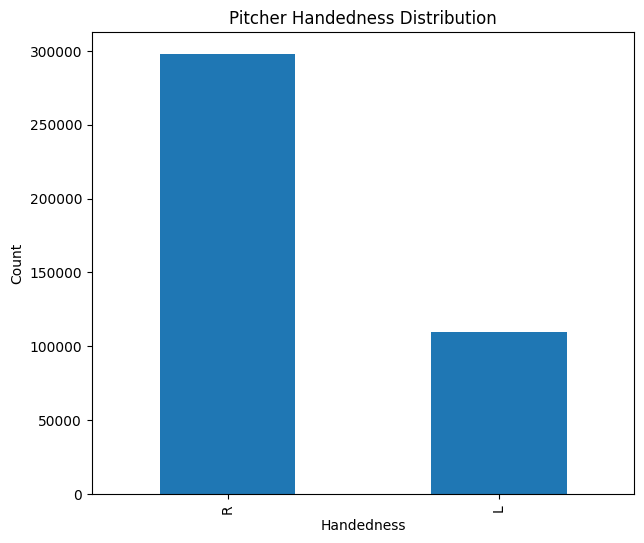

In [42]:
plt.figure(figsize=(7,6))
df["p_throws"].value_counts().plot(kind="bar")
plt.title("Pitcher Handedness Distribution")
plt.xlabel("Handedness")
plt.ylabel("Count")
plt.savefig("viz/handedness_distribution.png", dpi=300)
plt.show()

## 10. Pitch Velocity Distribution

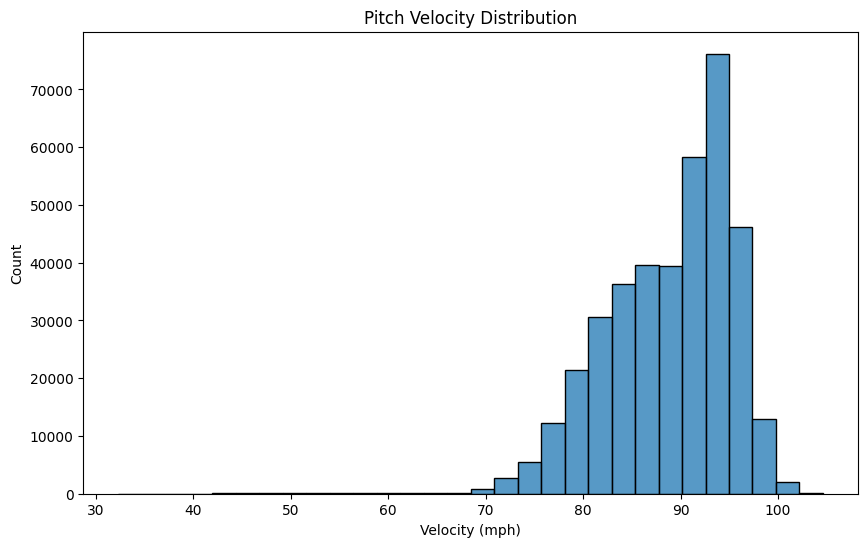

In [43]:
plt.figure(figsize=(10,6))
sns.histplot(df["release_speed"].dropna(), bins=30)
plt.title("Pitch Velocity Distribution")
plt.xlabel("Velocity (mph)")
plt.ylabel("Count")
plt.savefig("viz/pitch_velocity_hist.png", dpi=300)
plt.show()

## 11. Pitch Type Distribution

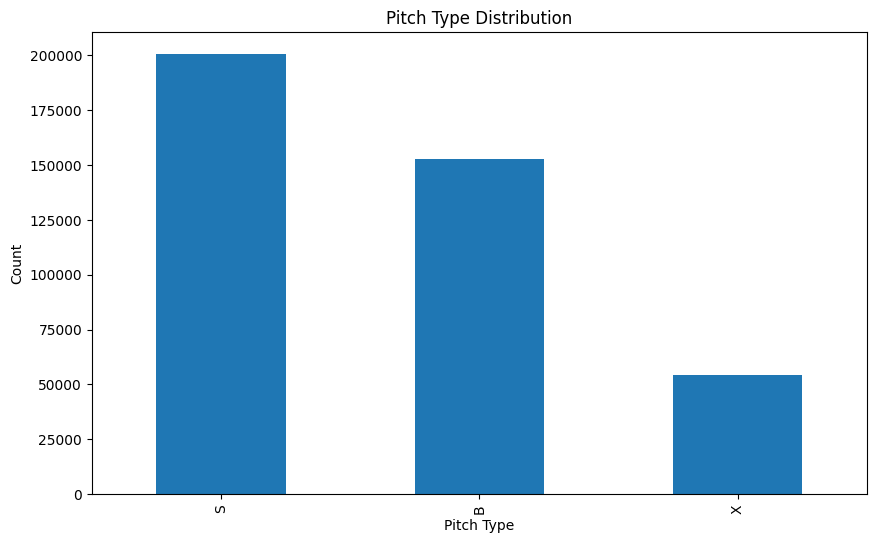

In [44]:
plt.figure(figsize=(10,6))
df["type"].value_counts().plot(kind="bar")
plt.title("Pitch Type Distribution")
plt.xlabel("Pitch Type")
plt.ylabel("Count")
plt.savefig("viz/pitch_type_distribution.png", dpi=300)
plt.show()

## 12. Pitch Type Usage Heatmap (Pitcher × Pitch Type)

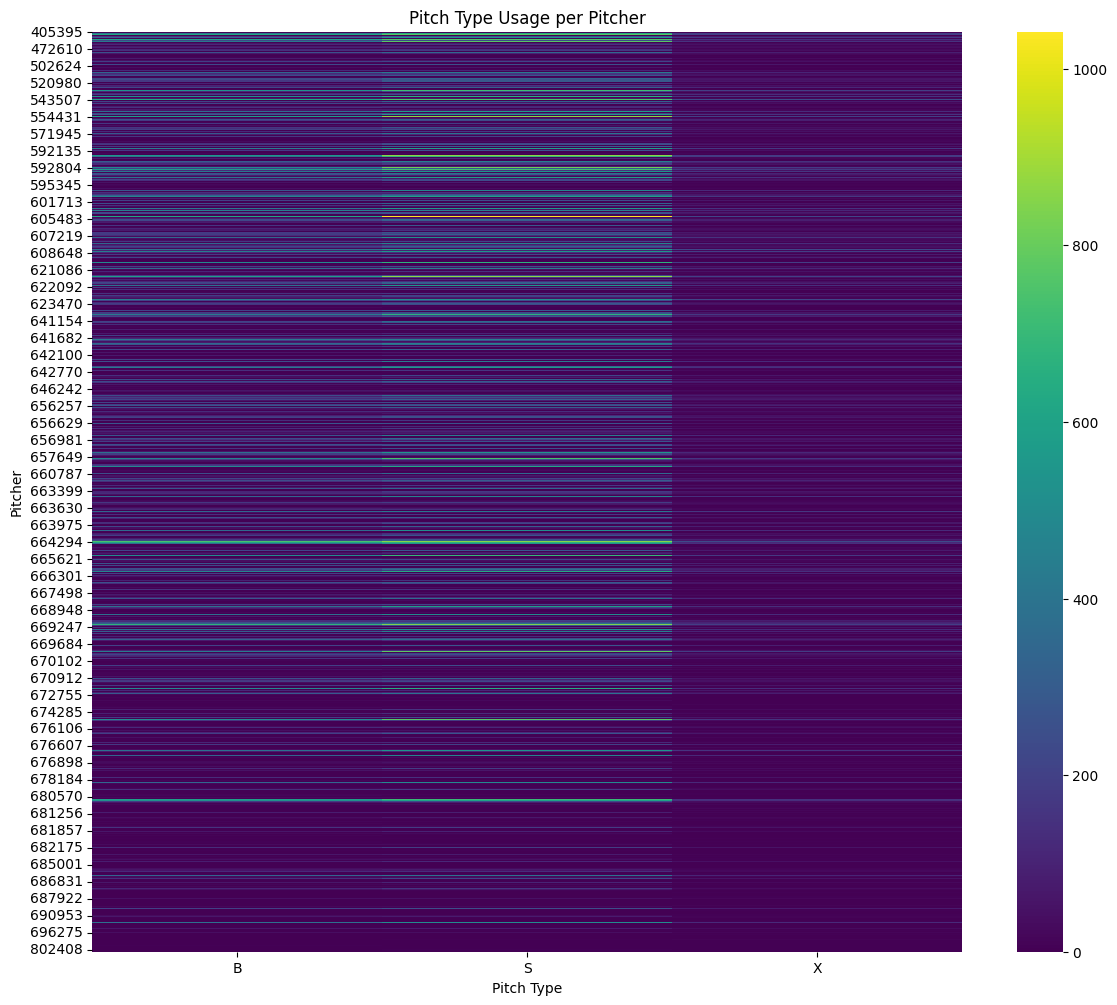

In [45]:
pivot = pd.crosstab(df["pitcher_on_mound"], df["type"])

plt.figure(figsize=(12,10))
sns.heatmap(pivot, cmap="viridis")
plt.tight_layout()
plt.title("Pitch Type Usage per Pitcher")
plt.xlabel("Pitch Type")
plt.ylabel("Pitcher")
plt.savefig("viz/pitcher_pitchtype_heatmap.png", dpi=300)
plt.show()

## 13. Correlation Heatmap

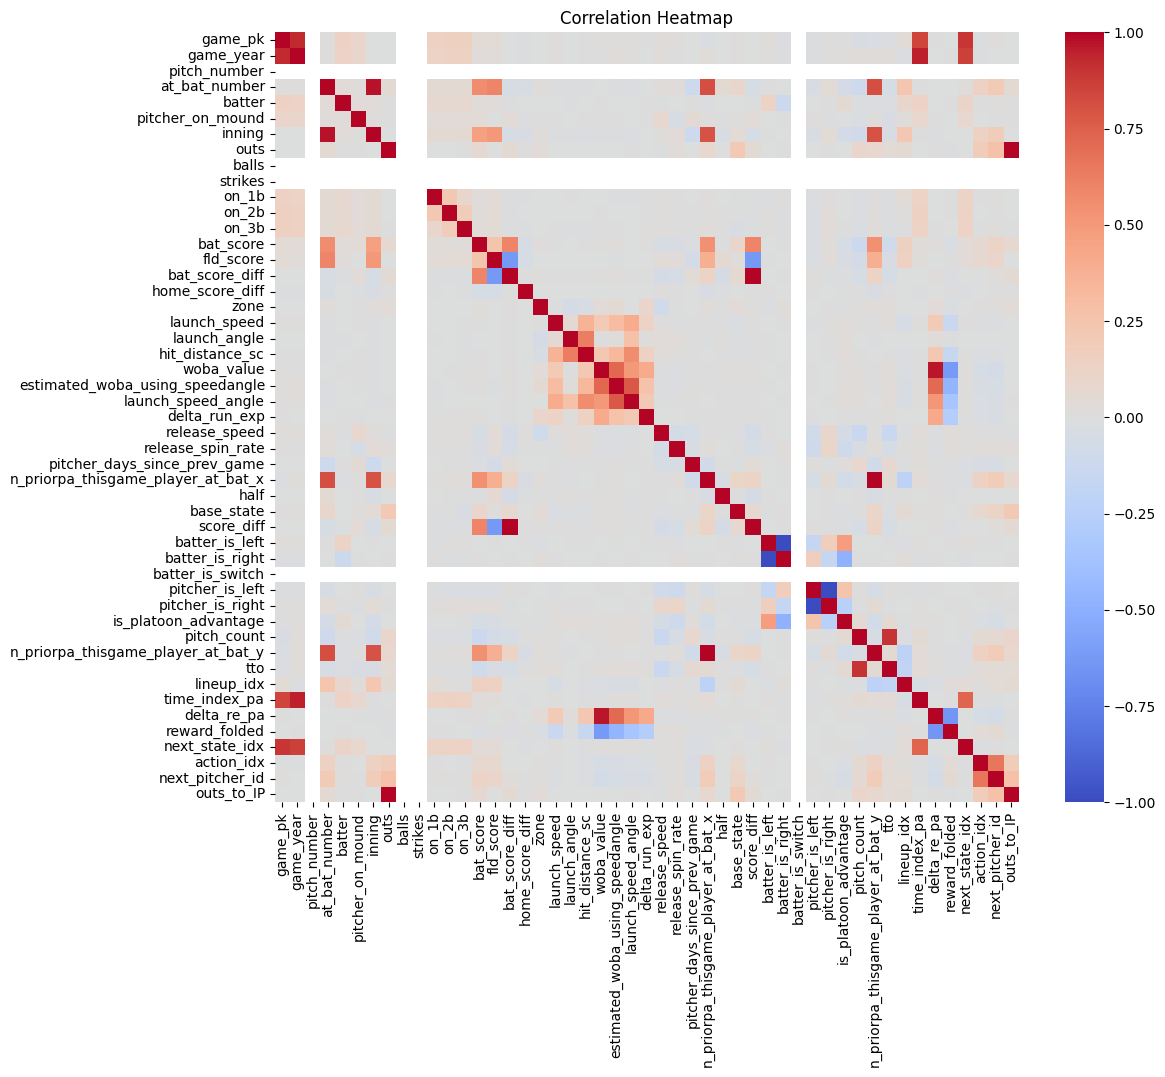

In [46]:
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes("number").corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("viz/correlation_heatmap.png", dpi=300)
plt.show()